In [8]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import yasa
from scipy.signal import welch
import seaborn as sns
from scipy.signal import welch, freqz, butter, filtfilt


In [3]:
# Load data

fs = 100
min_freq = 11
max_freq = 13

electrodes_all = pd.read_csv('100Hz/data_set_IVb_al_train_nfo.txt', header=None, delimiter=', ', nrows=1, engine='python')
electrodes_all = np.squeeze(electrodes_all.values.tolist())
electrodes_all = electrodes_all.tolist()
print(electrodes_all)

data = pd.read_csv('100Hz/data_set_IVb_al_train_cnt.txt', names=electrodes_all, delimiter='\t')
events = pd.read_csv('100Hz/data_set_IVb_al_train_mrk.txt', header=None, sep='\t')
events = np.squeeze(events.values.tolist())

C3_df = data['C3']
C3 = data['C3'].to_numpy()
C3 = np.reshape(C3, (C3.shape[0], 1))

print(C3)

['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6', 'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O2', 'OI1', 'OI2', 'I1', 'I2']
[[-46.5]
 [-39.6]
 [-37.5]
 ...
 [ 41.1]
 [ 71.2]
 [ 47.7]]


In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch


# Sort into left or right
def choppity_chop_data(data, ntrials):
    # Sort the data into their trials for left and right
    channels = data.shape[1]
    behind_event = 175
    front_event = 525
    total_len = behind_event + front_event
    
    right = np.zeros((total_len, ntrials))
    left = np.zeros((total_len, ntrials))
    
    right_trial_avg = np.zeros((channels, total_len))
    left_trial_avg = np.zeros((channels, total_len))
    
    for i in range(ntrials):
        start = events[i][0]
        trial = data[start - behind_event: start + front_event, :]

        if (events[i][1] == 1):
            right = np.append(right, trial, axis=1)
        else:
            left = np.append(left, trial, axis=1)
    
    
    right = right[:, ntrials:]
    left = left[:, ntrials:]
    
    return right.T, left.T


def plot_MI(data, title):
    R_trials, L_trials = choppity_chop_data(data, 210)

    # Square it
    R_trials, L_trials = np.square(R_trials), np.square(L_trials)

    # Average it
    R_trials_avg, L_trials_avg = np.mean(R_trials, axis=0), np.mean(L_trials, axis=0)

    # Plot data
    time = [i for i in range(-175, 525)]

    # Plot the signal
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(time, R_trials_avg, lw=1.5, color='c')
    plt.plot(time, L_trials_avg, lw=1.5, color='m')
    plt.legend(['Right hand', 'Left hand'])
    plt.xlabel('Time (100ms)')
    plt.ylabel('Power Squared')
    plt.title(title)
    plt.savefig(title)
    sns.despine()

    
# Referencing

def reference(ref_type, data, electrodes):
    assert (data.shape[0] > data.shape[1]), "Check your rows are samples and columns are electrodes: " + str(data.shape)        
    
    if (ref_type=='car'):
        ref = data - np.mean(data, axis = 1, keepdims = True)
    elif (ref_type=='cz'):
        cz_index = np.where(electrodes=='Cz')[0][0]
        cz = data[:, cz_index]
        cz = cz.reshape((data.shape[0], 1))
        ref = data - cz
    else:
        return "Error, lol"
    return ref

In [5]:
# Reference data
data_unref = data
data_ref = data.to_numpy()
data_ref = reference('car', data_ref, electrodes_all)
data_ref = pd.DataFrame(data_ref, columns=electrodes_all)

data_ref.head()

,Fp1,AFp1,Fpz,AFp2,Fp2,AF7,AF3,AF4,AF8,FAF5,...,PO8,OPO1,OPO2,O1,Oz,O2,OI1,OI2,I1,I2
0,-21.316102,-19.416102,15.183898,21.983898,-20.916102,4.483898,-13.016102,-25.716102,73.083898,-12.616102,...,44.083898,12.983898,-28.516102,-189.116102,19.583898,-108.716102,-113.016102,86.383898,-141.416102,27.583898
1,-8.489831,-3.489831,29.710169,34.210169,-6.989831,17.610169,1.310169,-12.789831,84.410169,3.010169,...,2.710169,-0.389831,-53.389831,-197.689831,-4.789831,-150.489831,-123.789831,47.610169,-151.689831,-29.689831
2,-5.276271,-8.176271,27.723729,32.223729,-9.676271,24.623729,-2.176271,-18.476271,90.623729,-2.476271,...,24.023729,1.323729,-42.276271,-196.876271,6.723729,-125.676271,-122.076271,73.823729,-151.276271,9.323729
3,2.792373,6.192373,41.992373,49.492373,6.092373,24.492373,10.892373,-1.907627,101.192373,5.992373,...,16.692373,-4.207627,-51.707627,-201.607627,4.292373,-132.307627,-127.607627,69.492373,-156.607627,-4.607627
4,-2.321186,-2.621186,32.278814,41.478814,-1.721186,22.178814,5.678814,-8.421186,98.278814,6.878814,...,12.978814,0.178814,-52.521186,-192.421186,5.678814,-136.821186,-117.921186,66.278814,-145.721186,-0.021186


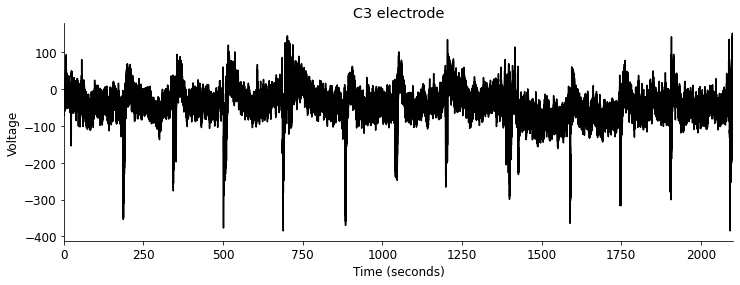

In [6]:
# Plot data
time = np.arange(C3.size) / fs

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, C3, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('C3 electrode')
sns.despine()

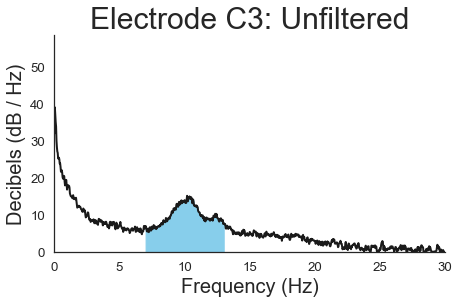

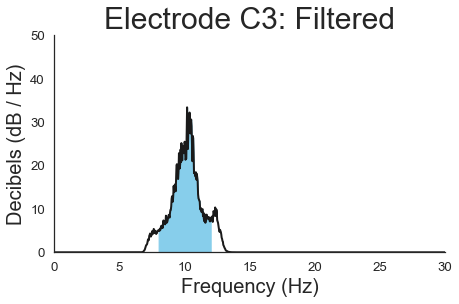

In [117]:
# Plot spectrum for unfiltered and define margin for signal
low = 8
high = 12
margin = 1

freqs, psd = plot_spectrum(C3_df, fs, (32), [1, 50], dB=True)

# Define mu band
# Find intersecting values in frequency vector
idx_mu = np.logical_and(freqs >= low-margin, freqs <= high+margin)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 30])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Unfiltered", fontsize=30)
sns.despine()

# Filter just C3 to just see the effects
C3_filt = butter_bandpass_filter(C3_df, low-margin, high+margin, fs, order=9)
freqs, psd = plot_spectrum(C3_filt, fs, (32), [low, high], dB=False)

# Define band
# Find intersecting values in frequency vector
idx_mu = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_mu, color='skyblue')
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Decibels (dB / Hz)', fontsize=20)
plt.xlim([0, 30])
plt.ylim([0, psd.max() * 1.5])
plt.title("Electrode C3: Filtered", fontsize=30)
sns.despine()

In [143]:
# Plot channel unfiltered vs filtered difference

def compare_filt(data, electrode, low, high, order):
    elect_df = data[electrode]
    
    # Plot spectrum for unfiltered
    freqs, psd = plot_spectrum(elect_df, fs, (32), [1, 50], dB=True)
  
    # Filter
    elect_df_filt = butter_bandpass_filter(elect_df, low, high, fs, order=order)
    freqs, psd = plot_spectrum(elect_df_filt, fs, (32), [20, 40], dB=True)

    # Plot MI for unfiltered & filtered
    elect_df = elect_df.to_numpy()
    elect_df = np.reshape(elect_df, (elect_df_filt.shape[0], 1))
    elect_df_filt = np.reshape(elect_df_filt, (elect_df_filt.shape[0], 1))
    
    R_trials1, L_trials1 = choppity_chop_data(elect_df, 210)
    R_trials2, L_trials2 = choppity_chop_data(elect_df_filt, 210)
    
    # Square it
    R_trials1, L_trials1 = np.square(R_trials1), np.square(L_trials1)
    R_trials2, L_trials2 = np.square(R_trials2), np.square(L_trials2)

    # Average it
    R_trials_avg1, L_trials_avg1 = np.mean(R_trials1, axis=0), np.mean(L_trials1, axis=0)
    R_trials_avg2, L_trials_avg2 = np.mean(R_trials2, axis=0), np.mean(L_trials2, axis=0)


    # Plot the signal
    time = [i for i in range(-1750, 5250, 10)]
    # Plot comparison graph
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True)
#     fig.suptitle('Electrode ' + electrode + ': filtered (' + str(low) + '-' + str(high) + 'Hz) vs unfiltered')
#     fig. tight_layout() 
    
#     ax1.plot(time, R_trials_avg1, lw=1.5, color='c')
#     ax1.plot(time, L_trials_avg1, lw=1.5, color='m')
#     ax1.legend(['RH', 'LH'])
#     ax1.set(ylabel='Power ' + r'$(mV^2$)')
    
#     ax2.plot(time, R_trials_avg2, lw=1.5, color='c')
#     ax2.plot(time, L_trials_avg2, lw=1.5, color='m')
#     ax2.legend(['RH', 'LH'])
#     ax2.set(xlabel='Time (ms)')
#     ax2.set(ylabel='Power ' + r'$(mV^2$)')

    # Plot a single graph
    fig = plt.figure(figsize=(14, 7))
    plt.title('Electrode ' + electrode + ': filtered (' + str(low) + '-' + str(high) + 'Hz)', fontsize=30)
    plt.plot(time, R_trials_avg2, lw=1.5, color='c')
    plt.plot(time, L_trials_avg2, lw=1.5, color='m')
    plt.legend(['RH', 'LH'])
    plt.xlabel('Time (ms)')
    plt.ylabel('Power ' + r'$(mV^2$)')
    
#     ax2.set(ylabel='Power ' + r'$(\mu V$)')#     fig.savefig('Electrode ERP graphs/' + str(electrode))

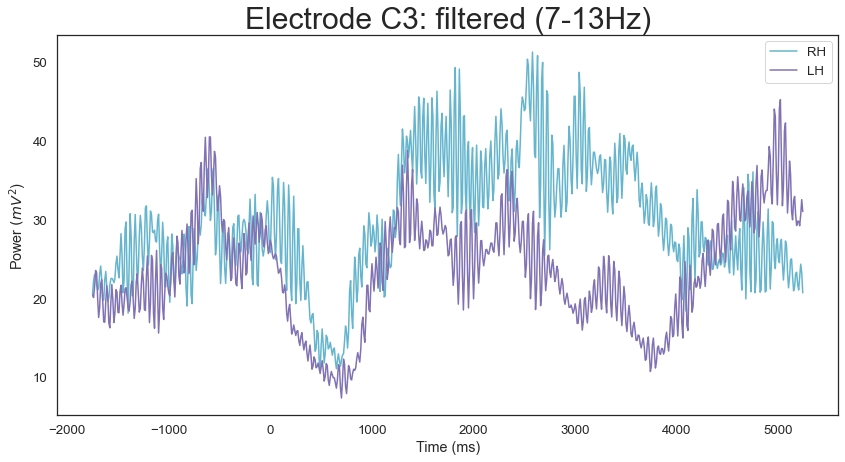

In [144]:
# Print all graphs

C3_ind = electrodes_all.index('C3')
C4_ind = electrodes_all.index('C4')

compare_filt(data_ref, electrodes_all[C3_ind], 7, 13, 11)=

In [165]:
# Plot channel unfiltered vs filtered difference

def compare_ref(data, electrode, low, high, order):
    elect_df = data[electrode]
    elect_df_ref = data_ref[['C3']]

    # Plot MI for unfiltered & filtered
    elect_df_ref = elect_df_ref.to_numpy()
    elect_df_ref = np.reshape(elect_df_ref, (elect_df_ref.shape[0], 1))
    
    elect_df = elect_df.to_numpy()
    elect_df = np.reshape(elect_df, (elect_df.shape[0], 1))

    R_trials1, L_trials1 = choppity_chop_data(elect_df, 210)
    R_trials2, L_trials2 = choppity_chop_data(elect_df_ref, 210)
    
    # Square it
    R_trials1, L_trials1 = np.square(R_trials1), np.square(L_trials1)
    R_trials2, L_trials2 = np.square(R_trials2), np.square(L_trials2)

    # Average it
    R_trials_avg1, L_trials_avg1 = np.mean(R_trials1, axis=0), np.mean(L_trials1, axis=0)
    R_trials_avg2, L_trials_avg2 = np.mean(R_trials2, axis=0), np.mean(L_trials2, axis=0)

    # Plot the signal
    time = [i for i in range(-1750, 5250, 10)]
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True)
    fig.suptitle('Electrode ' + electrode + ' raw data: referenced vs unreferenced')
    fig. tight_layout() 
    
    # unreferenced signal
    ax1.plot(time, R_trials_avg1, lw=1.5, color='c')
    ax1.plot(time, L_trials_avg1, lw=1.5, color='m')
    ax1.legend(['RH', 'LH'])
    ax1.set(ylabel='Power ' + r'$(mV^2$)')
    
    # rereferenced signal
    ax2.plot(time, R_trials_avg2, lw=1.5, color='c')
    ax2.plot(time, L_trials_avg2, lw=1.5, color='m')
    ax2.legend(['RH', 'LH'])
    ax2.set(xlabel='Time (ms)')
    ax2.set(ylabel='Power ' + r'$(mV^2$)')

#     fig = plt.figure(figsize=(14, 7))
#     plt.title('Electrode ' + electrode + ': filtered (' + str(low) + '-' + str(high) + 'Hz)', fontsize=30)
#     plt.plot(time, R_trials_avg2/10000, lw=1.5, color='c')
#     plt.plot(time, L_trials_avg2/10000, lw=1.5, color='m')
#     plt.legend(['RH', 'LH'])
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Power ' + r'$(\mu V$)')
    
#     ax2.set(ylabel='Power ' + r'$(\mu V$)')#     fig.savefig('Electrode ERP graphs/' + str(electrode))

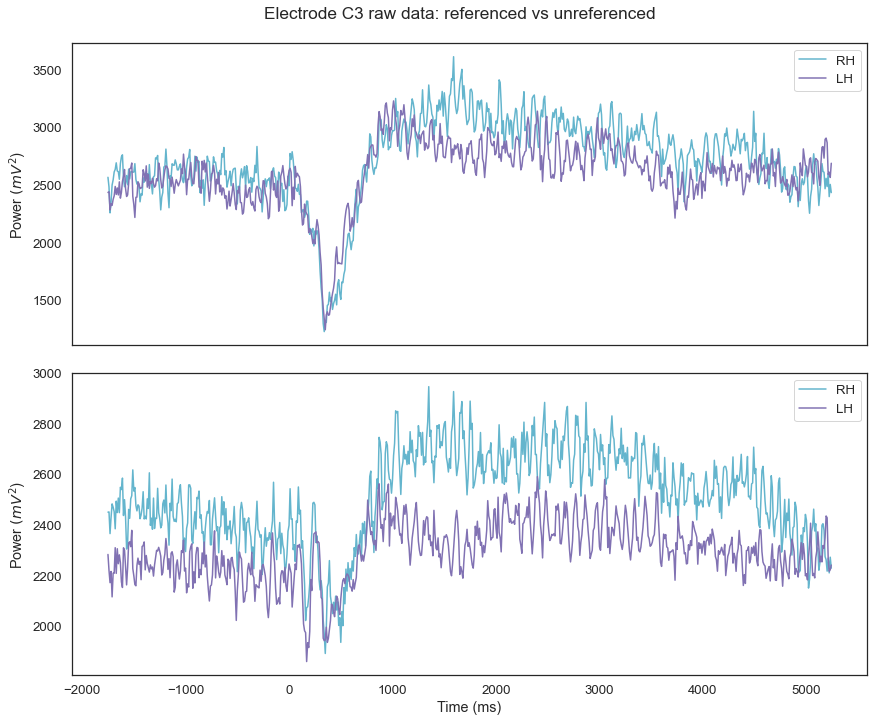

In [166]:
compare_ref(data_unref, electrodes_all[C3_ind], 7, 13, 11)